In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [4]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [5]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Currency Crises':'currency_crisis',
                    'Inflation Crises':'inflation_crisis',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)

data['Year'] = data['Year'].astype(int)

columns_to_convert = ['banking_crisis', 'systemic_crisis', 'annual_inflation', 'currency_crisis', 'inflation_crisis']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [6]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)

# 1. Selecting countries for global analysis

In [7]:
from dataset import concat_dataset
from dataset import dummy_variable

In [8]:
from functionsB import compute_crisis_duration
from functionsB import length_frequency

In [9]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
UE = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#List for all countries
unique_countries_df1 = set(data['CC3'].unique())
unique_countries_df2 = set(GDP_pc['Code'].unique())
ALL = list(unique_countries_df1.intersection(unique_countries_df2))

#Select a list among those listed above:
countries_selected = ['ITA']
#Create a dataset with the data of the countries of the list
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')
dummy_variable(global_data)

In [10]:
banking_crisis_only_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')
banking_crisis_only_first_year

In this approch, we record 10 different crisis event.


[1866, 1889, 1891, 1893, 1907, 1914, 1930, 1935, 1990, 2008]

In [11]:
def compute_crisis_duration(dataset):
    crisis_duration = []
    current_length = 0
    last_index = 0

    for index, row in dataset.iterrows():
        if current_length > 0:
            if row['banking_crisis'] == 1 and row['banking_crisis_only_first_year'] != 1:
                current_length += 1
            elif row['excluded_years']==1:
                if index < last_index + 9:
                    current_length = 0
            elif row['banking_crisis_only_first_year'] == 1:
                    crisis_duration.append(current_length)
                    current_length = 1
                    last_index = index

        elif row['banking_crisis_only_first_year'] == 1:
                current_length = +1
                last_index = index

    # Check if the last sequence extends to the end of the dataset
    if current_length > 0:
        crisis_duration.append(current_length)

    return crisis_duration

In [12]:
crisis_duration = compute_crisis_duration(global_data)
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,4,8
1,2,1,4
2,3,1,3
3,6,1,2
4,7,1,1


In [13]:
print(len(crisis_duration))
crisis_duration

8


[3, 1, 1, 1, 1, 2, 6, 7]

# 2. Extracting inflation series

In [14]:
from functionsB import extract_inflation_series
from functionsB import normalize_crisis_data

In [15]:
print(banking_crisis_only_first_year)

[1866, 1889, 1891, 1893, 1907, 1914, 1930, 1935, 1990, 2008]


In [16]:
inflation_series = extract_inflation_series(global_data)
norm_inflation_series = normalize_crisis_data(inflation_series)
print(len(inflation_series))
inflation_series

7


[[-1.1, 0.0, 2.2, 4.3, 1.0, 1.0, 3.0, 12.7, 6.1, 2.5],
 [2.0, 1.9, 2.8],
 [2.8, 0.0, -0.9],
 [-0.9, -1.9, 0.0, -0.9, 0.0, 0.0, 0.0, -1.9, 1.0, 0.0],
 [0.9, 5.5, -0.9, -2.6, 2.7, 1.8, 1.7, 0.0],
 [2.1, -11.2, -3.7, -1.9, -3.4, -6.6],
 [2.0, 3.5, 0.8, 1.6, 2.9, 3.3, 1.2, 0.2, 0.1, 0.2]]

## 2.1 Inflation response to each year of crisis

In [17]:
from visualisation import plot_by_crisis_length

In [18]:
# plot_by_crisis_length(norm_inflation_series, crisis_duration, len_freq, 'Inflation rate')

# 3. Extracting output gap series

In [19]:
from functionsB import extract_output_gap_series

In [20]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
dummy_variable(global_data_inner)


In [21]:
banking_crisis_only_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 10 different crisis event.


In [22]:
crisis_duration = compute_crisis_duration(global_data_inner)
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,4,8
1,2,1,4
2,3,1,3
3,6,1,2
4,7,1,1


In [23]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

7

## 3.1 Output gap response for each length of crisis

In [24]:
# plot_by_crisis_length(output_gap_series, crisis_duration, len_freq, 'Output-gap')

# 4. Crisis & recovery Dynamics in a multiple country database

In [25]:
from functionsB import inflation_dynamics
from functionsB import output_gap_dynamics

In [26]:
from visualisation import plot_dynamics

9
8


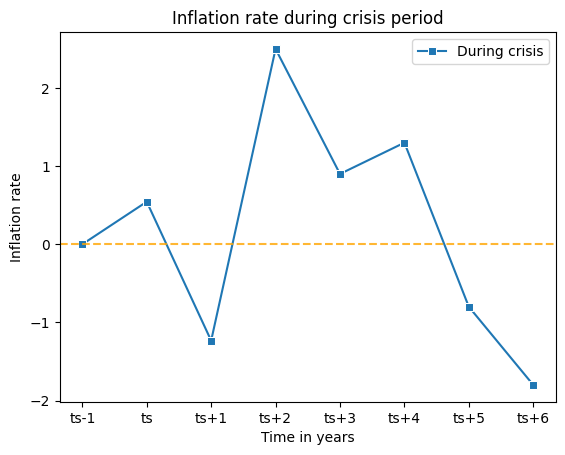

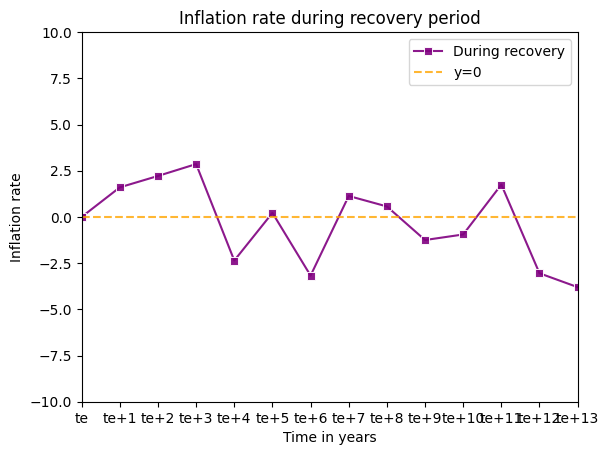

In [27]:
inflation_crisis_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = True))
inflation_recovery_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = False))
print(len(inflation_crisis_series))
print(len(inflation_recovery_series))
plot_dynamics(inflation_crisis_series, inflation_recovery_series, 'Inflation rate')

10
8


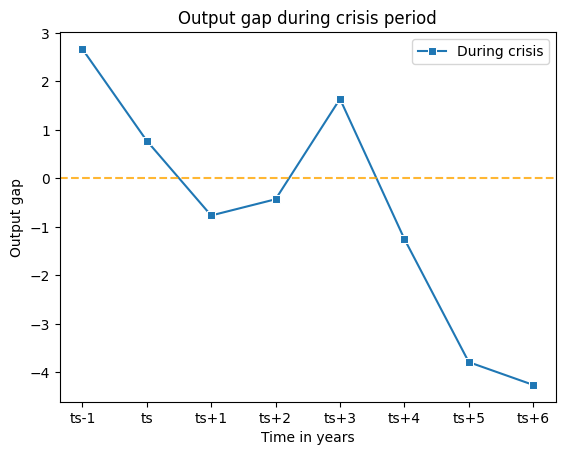

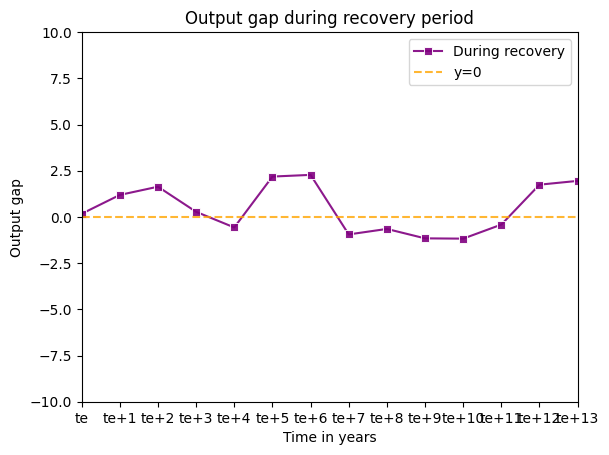

In [28]:
output_gap_crisis_series = output_gap_dynamics(global_data_inner, during_crisis = True)
output_gap_recovery_series = output_gap_dynamics(global_data_inner, during_crisis = False)
print(len(output_gap_crisis_series))
print(len(output_gap_recovery_series))
plot_dynamics(output_gap_crisis_series, output_gap_recovery_series, 'Output gap')